# Используемые модули

In [3]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report,confusion_matrix
from collections import Counter
import seaborn as sns
from tqdm import tqdm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings("ignore")

# Описание набора данных

В этой работе используется датасет [Reuters_50_50](https://archive.ics.uci.edu/ml/datasets/Reuter_50_50), содержащий тексты \(50\) авторов, предварительно категоризованных по авторам. Тексты содержат буквы стандартного латинского алфавита и знаки пунктуации. Набор данных состоит двух колонок:

*   <b>text</b> — текст;
*   <b>author</b> — автор (класс).

Целью является построение классификатора, способного определять авторство текста.



# Разведочный анализ данных

Считайте набор данных в датафрейм.

In [6]:
df = pd.read_csv("sources/Text_by_Author.csv")
df

,text,author
0,China is firming up a shortlist of foreign ban...,GrahamEarnshaw
1,The most magnificent building of old Shanghai ...,GrahamEarnshaw
2,"China's personal bank deposits, which surged i...",GrahamEarnshaw
3,Chinese authorities have closed their eyes to ...,GrahamEarnshaw
4,The crackdown on China's young stock markets h...,GrahamEarnshaw
...,...,...
4995,Beijing's propaganda machine has accused the U...,BenjaminKangLim
4996,China's propaganda machine had a field day on ...,BenjaminKangLim
4997,North Korea said on Monday it would fire a top...,BenjaminKangLim
4998,"China has pledged to edge open its insurance, ...",BenjaminKangLim


Определите сбалансированность датасета. Постройте столбчатую диаграмму распределения количества текстов по авторам. Определите какое количество текстов автора <code>BenjaminKangLim</code> содержится в наборе данных

In [7]:
df.loc[df['author'] == "BenjaminKangLim"]

,text,author
2450,China sent a senior official to attend a recep...,BenjaminKangLim
2451,China called on Taiwan on Tuesday to show good...,BenjaminKangLim
2452,China demanded on Monday that the United State...,BenjaminKangLim
2453,Chinese President Jiang Zemin tried to reassur...,BenjaminKangLim
2454,China pledged on Wednesday to curb a rush by p...,BenjaminKangLim
...,...,...
4995,Beijing's propaganda machine has accused the U...,BenjaminKangLim
4996,China's propaganda machine had a field day on ...,BenjaminKangLim
4997,North Korea said on Monday it would fire a top...,BenjaminKangLim
4998,"China has pledged to edge open its insurance, ...",BenjaminKangLim


Постройте распределение авторов по средней длине текста. Определите авторов с самым длинным и самым коротким в среднем текстами.

Автор с самым коротким в среднем текстом: JimGilchrist
Средняя длина текста: 1994.44 символов
Автор с самым длинным в среднем текстом: PeterHumphrey
Средняя длина текста: 3629.14 символов
               Author  Article Count
0      GrahamEarnshaw            100
1        JimGilchrist            100
2       AaronPressman            100
3         SimonCowell            100
4           KeithWeir            100
5         KarlPenhaul            100
6          MartinWolk            100
7      AlexanderSmith            100
8       JaneMacartney            100
9            TanEeLyn            100
10          NickLouth            100
11      PeterHumphrey            100
12       MarkBendeich            100
13         TimFarrand            100
14       JohnMastrini            100
15   DarrenSchuettler            100
16        DavidLawder            100
17      EdnaFernandes            100
18    LynnleyBrowning            100
19     KevinDrawbaugh            100
20          LydiaZajc            10

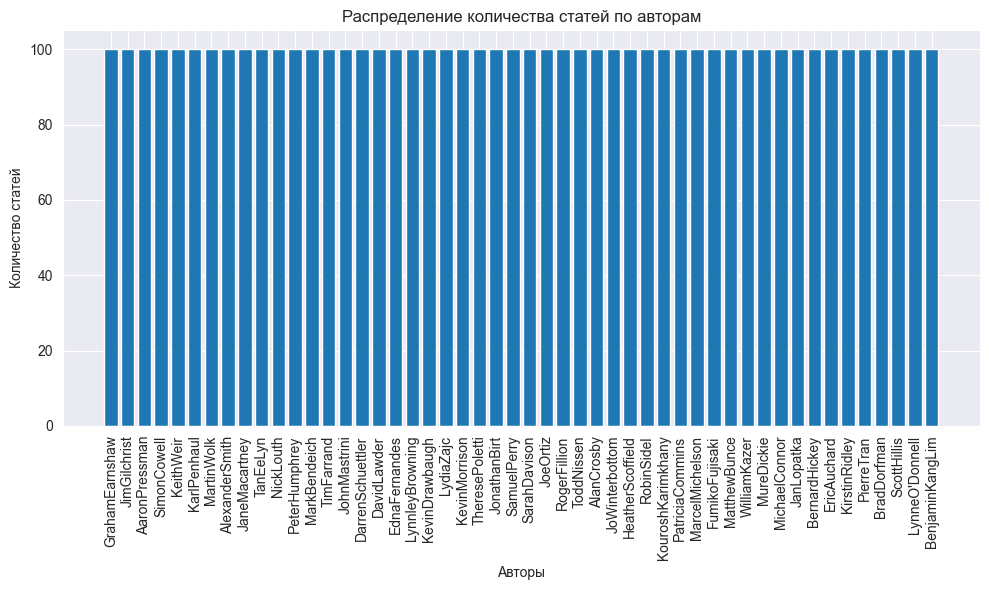

In [10]:
df['length'] = df['text'].apply(len)

author_stats = df.groupby('author')['length'].mean().reset_index()

shortest_author = author_stats.loc[author_stats['length'].idxmin()]
longest_author = author_stats.loc[author_stats['length'].idxmax()]

print(f"Автор с самым коротким в среднем текстом: {shortest_author['author']}")
print(f"Средняя длина текста: {shortest_author['length']} символов")
print(f"Автор с самым длинным в среднем текстом: {longest_author['author']}")
print(f"Средняя длина текста: {longest_author['length']} символов")

author_counts = df['author'].value_counts().reset_index()
author_counts.columns = ['Author', 'Article Count']

print(author_counts)

# Построение распределения
plt.figure(figsize=(10, 6))
plt.bar(author_counts['Author'], author_counts['Article Count'])
plt.xticks(rotation=90)
plt.xlabel('Авторы')
plt.ylabel('Количество статей')
plt.title('Распределение количества статей по авторам')
plt.tight_layout()
plt.show()

# Базовые модели

В качестве базовой модели можно рассмотреть построение наивного байесовского классификатора ([<code>MultinomialNB</code>](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)). Для генерации признаков на основе частот слов в тексте используйте [<code>CountVectorizer</code>](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) библиотеки sklearn.

При помощи <code>train_test_split</code> разбейте исходный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке отклика.

In [12]:
X = df['text']
y = df['author']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=y)

Обучите модель <code>CountVectorizer</code> на тренировочных данных с параметрами по умолчанию. Примените полученное преобразование для тренировочных и тестовых данных. Определите размерность пространства признаков после преобразования.

In [18]:
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

print(f"Размерность признаков: {X_train_counts.shape[1]}")

Размерность признаков: 36681


Обучите модель <code>MultinomialNB</code> на тренировочных данных, оцените на тестовых. Вычислите <code>f1_score(average='weighted')</code> модели на тестовых данных.

In [28]:
nb = MultinomialNB()
nb.fit(X_train_counts, y_train)
y_pred_nb = nb.predict(X_test_counts)

f1_weighted_nb = f1_score(y_test, y_pred_nb, average='weighted')
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)
print("f1_score (взвешенный):", f1_weighted_nb)

f1_score (взвешенный): 0.8166886369373525


Определите автора с самым низким значением <code>f1_score</code>.

In [21]:
authors_f1 = {}
for k, v in report_nb.items():
    if k.isalpha() and isinstance(v, dict) and 'f1-score' in v:
        authors_f1[k] = v['f1-score']

if authors_f1:
    min_f1 = min(authors_f1.values())
    worst_authors = sorted([k for k, v in authors_f1.items() if v == min_f1])
    worst_author = worst_authors[0]
    print(f'Автор с самым низким f1-score: {worst_author}, f1-score: {min_f1}')
else:
    print('Нет авторов с доступными f1-score.')

Автор с самым низким f1-score: TanEeLyn, f1-score: 0.3333333333333333


Постройте <code>[confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)</code> для тестового набора данных. Определите, с кем из авторов чаще всего путала модель автора с самым низким значением <code>f1_score</code>. Если таких авторов несколько, введите имя первого по алфавиту.

In [25]:
cm = confusion_matrix(y_test, y_pred_nb, labels=nb.classes_)
worst_idx = list(nb.classes_).index(worst_author)
errors = cm[worst_idx].copy()
errors[worst_idx] = 0
confused_idx = errors.argmax()
confused_author = nb.classes_[confused_idx]
cm

array([[16,  0,  0, ...,  0,  0,  0],
       [ 0, 19,  0, ...,  0,  0,  0],
       [ 0,  0, 18, ...,  0,  0,  0],
       ...,
       [ 0,  0,  1, ..., 18,  0,  0],
       [ 0,  0,  0, ...,  0, 15,  0],
       [ 0,  0,  0, ...,  0,  0,  8]])

Имеет смысл рассмотреть ансамбль моделей, например, <code>[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)</code>. Кроме того стоит рассмотреть и другие способы извлечения признаков.

При помощи <code>train_test_split</code> разбейте исходный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке отклика.

Обучите модель <code>[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)</code> на тренировочных данных с параметрами по умолчанию. Примените полученное преобразование для тренировочных и тестовых данных.

Обучите модель <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании. Вычислите <code>f1_score(average='weighted')</code> модели на тестовых данных.

In [26]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(
    X, y, test_size=0.2, random_state=27, stratify=y
)

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train_tf)
X_test_tfidf = tfidf.transform(X_test_tf)

rf = RandomForestClassifier(random_state=27)
rf.fit(X_train_tfidf, y_train_tf)
y_pred_rf = rf.predict(X_test_tfidf)
f1_weighted_rf = f1_score(y_test_tf, y_pred_rf, average='weighted')
print(f"""
Ответы:
1. Автор с самым низким F1-score: {worst_author}
2. F1-score автора: {authors_f1[worst_author]:.3f}
3. Автор путаницы: {confused_author}
4. F1-score RandomForest: {f1_weighted_rf:.3f}
""")


Ответы:
1. Автор с самым низким F1-score: TanEeLyn
2. F1-score автора: 0.333
3. Автор путаницы: PeterHumphrey
4. F1-score RandomForest: 0.826



# Предварительная обработка текста

Векторизаторы из библиотеки <code>sklearn</code> частично обрабатывают текст перед построением векторных представлений. Однако, можно попробовать улучшить качество классификации за счет более глубокой предваретильной обработки текста. Для этого стоит рассмотреть возможности библиотеки <code>[NLTK](https://www.nltk.org/)</code> в контексте токенизации, лемматизации и удаления стоп слов.

## Пример предварительной обработки текста средствами NLTK

Импорт необходимых модулей

In [32]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Список стоп-слов
nltk.download('stopwords')
# Модуль пунктуации
nltk.download('punkt')
# Модуль wordnet для лемматизации
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

Импорт списка стоп-слов

In [33]:
STOPWORDS = set(stopwords.words('english'))
print('Фрагмент списка стоп-слов: ', STOPWORDS[:10])

Фрагмент списка стоп-слов:  ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


Токенизация

In [34]:
# Тестовый текст
txt = df['text'].iloc[0]

# Приведение к нижнему регистру
txt = txt.lower()

# Токенизация
tokenized_text = word_tokenize(txt)

# Список токенов
print(tokenized_text[:10])

['china', 'is', 'firming', 'up', 'a', 'shortlist', 'of', 'foreign', 'banks', 'that']


Лемматизация

In [35]:
# Модель лемматизации
lemmatizer = WordNetLemmatizer()

# Лемматизация
lemmas = [lemmatizer.lemmatize(token) for token in tokenized_text]

# Список лемм
print(lemmas[:10])

['china', 'is', 'firming', 'up', 'a', 'shortlist', 'of', 'foreign', 'bank', 'that']


Удаление лемм, входящих в список стоп-слов и небуквенных токенов (при помощи <code>str.isalpha()</code>).

In [36]:
cleaned_text = [word for word in lemmas if word not in STOPWORDS and str.isalpha(word)]
print(cleaned_text[:10])
print('Лемм до очистки: ', len(lemmas))
print('Лемм после очистки: ', len(cleaned_text))

['china', 'firming', 'shortlist', 'foreign', 'bank', 'allowed', 'local', 'renminbi', 'currency', 'business']
Лемм до очистки:  479
Лемм после очистки:  213


## Функция предварительной обработки

Используя код из рассмотренного выше примера, создайте функцию <code>custom_preprocess(txt)</code> для предварительной обработки текста в следующей последовательности:

*   Приведение к нижнему регистру
*   Токенизация
*   Лемматизация
*   Удаление стоп-слов и небуквенных токенов

На вход функция принимает текст. Возвращать функция должна текстовую строку, в которой все полученные леммы отделены пробелами.




In [47]:
def custom_preprocess(txt):
  txt = txt.lower()
  tokenized_text = word_tokenize(txt)
  lemmas = [lemmatizer.lemmatize(token) for token in tokenized_text]
    
  cleaned_text = [word for word in lemmas if word not in STOPWORDS and str.isalpha(word)]
    
  return ' '.join(cleaned_text)

In [50]:
# custom_preprocess(df['text'].iloc[14])
# Проверка, что функция описана корректно
assert custom_preprocess(df['text'].iloc[14]) == 'threat textile trade war little impact chinese firm unlikely go beyond word company performing poorly company official broker said wednesday company official said got used continual verbal duelling beijing washington concrete measure avoided last minute interest side stake verbal warning finally replaced mutual concession said li shounan head general manager office shanghai lianhua fibre co overall amount threat large come individual company impact even le expect much effect said official shanghai sanmao textile co spokeswoman shanghai jiafeng co ltd said product involved dispute surely impact trade war break though hard immediately ass extent said china annual apparel textile export united state estimated around billion garment textile company listed shanghai shenzhen recent clash trade relation beijing said sunday would temporarily ban import selected textile farm good fruit alcoholic drink december retaliation sanction taken chinese textile washington announced september would cut china textile import quota million retaliation accusing china shipping third country avoid quota agreed upon bilateral textile accord textile company performed poorly past two year due slump industry expect major impact even trade war said one broker china shandong security handful firm closely linked trade possibly affected added care said investment analyst hong kong security brokerage listed textile firm done poorly investor interested chinese official said believe political agenda behind trade threat china penalty announced election believe closely linked president bill clinton political need said one official'

# Классификация

При помощи <code>train_test_split</code> разбейте исходный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке отклика.

Обучите модель <code>TfidfVectorizer</code> на тренировочных данных, с использованием описанной ранее функции предобработки (<code>preprocessor=custom_preprocess</code>). Примените полученное преобразование для тренировочных и тестовых данных.

Определите размерность полученного пространства признаков.

In [51]:
X_preprocessed = X.apply(custom_preprocess)

X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, 
    y, 
    test_size=0.2, 
    random_state=27, 
    stratify=y
)

tfidf = TfidfVectorizer(preprocessor=lambda x: x)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Размерность пространства признаков: {X_train_tfidf.shape[1]}")

Размерность пространства признаков: 30257


Обучите модель <code>RandomForestClassifier</code> на тренировочных данных c параметрами, указанными в вашем индивидуальном задании. Вычислите <code>f1_score(average='weighted')</code> модели на тестовых данных.

In [52]:
rf = RandomForestClassifier(random_state=27)
rf.fit(X_train_tfidf, y_train)

y_pred = rf.predict(X_test_tfidf)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Weighted F1-score: {f1:.3f}")

Weighted F1-score: 0.811
